### Example of weighing the multi-task loss with uncertainty
This is a `torchmtl` implementation of the paper [Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics](https://arxiv.org/abs/1705.07115).
Large fractions of this notebook are borrowed from Yarin Gal's [example implementation](https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example-pytorch.ipynb).

In [1]:
# PyTorch imports
import torch
from torch import nn
import torch.optim as optim
from torch.nn import (Linear, Sequential, MSELoss)

# Import networkx for visualization
import networkx as nx

# torchMTL imports
from torchmtl import MTLModel
from torchmtl.wrapping_layers import Concat

# Some imports for the visualization
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(0)
torch.manual_seed(0)

def gen_data(N):
    X = np.random.randn(N, input_size)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, output1_size)
    w2 = 3.
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, output2_size)
    return X, Y1, Y2

def shuffle_data(X, Y1, Y2):
    s = np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s], Y1[s], Y2[s]

Now, we define the multi-task model ...

In [2]:
nb_features = 1024
input_size = 1
hidden_size = 2  # total number of output
output1_size = 1  # first output
output2_size = 1  # second output

# Define a loss function that returns the log vars
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, num_tasks):
        super(MultiTaskLossWrapper, self).__init__()
        self.num_tasks = num_tasks
        self.log_vars = nn.Parameter(torch.zeros((num_tasks)))

    def forward(self, *X):
        # Return the log vars so precision can be computed
        # in the training loop. Also return the predictions.
        return self.log_vars, X

tasks = [
        {
            'name': "InputTask",
            'layers': Sequential(*[nn.Linear(input_size, hidden_size), nn.ReLU()]),
            # No anchor_layer means this layer receives input directly
        },    
        {
            'name': "Lin1",
            'layers': nn.Linear(hidden_size, output1_size),
            'anchor_layer': "InputTask"
        },    
        {
            'name': "Lin2",
            'layers': nn.Linear(hidden_size, output2_size),
            'anchor_layer': "InputTask"
        },
        {
            'name': "MultiLoss",
            'layers': MultiTaskLossWrapper(num_tasks=2),
            'anchor_layer': ['Lin1', 'Lin2']
        }
    ]

... define from which layers we would like to receive predictions (output of their 'layers' key), loss function, and scaling factor. 

In [3]:
output_tasks=['MultiLoss']

... and build and visualize it

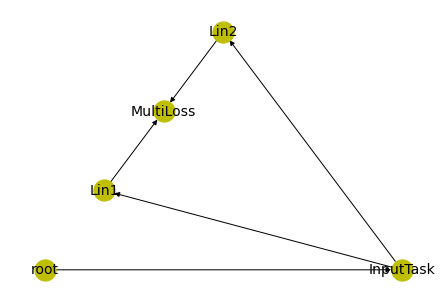

In [4]:
model = MTLModel(tasks, output_tasks=output_tasks)

pos = nx.planar_layout(model.g)
nx.draw(model.g, pos, font_size=14, node_color="y", node_size=450, with_labels=True)

In [5]:
# Define an optimizer
optimizer = optim.Adam(model.parameters())

# Generate the data set
N = 100
nb_epoch = 2000
batch_size = 20

# Generate and convert data into torch from numpy array
X, Y1, Y2 = gen_data(N)
X = X.astype('float32')
Y1 = Y1.astype('float32')
Y2 = Y2.astype('float32')

losses = []
for i in range(nb_epoch):

    epoch_loss = 0 
    X, Y1, Y2 = shuffle_data(X, Y1, Y2)
    
    for j in range(N//batch_size):
        optimizer.zero_grad()

        X_ = torch.from_numpy(X[(j * batch_size):((j + 1) * batch_size)])
        target1 = torch.from_numpy(Y1[(j * batch_size):((j + 1) * batch_size)])
        target2 = torch.from_numpy(Y2[(j * batch_size):((j + 1) * batch_size)])
        y = [target1, target2]
        
        multi_loss_out, _, _ = model(X_)
        log_vars = multi_loss_out[0][0]
        y_hat = multi_loss_out[0][1]

        loss = 0
        for i in range(len(y)):
            precision = torch.exp(-log_vars[i])
            diff = (y_hat[i] - y[i])**2.
            loss += torch.sum(precision * diff + log_vars[i], -1)  
        loss = torch.mean(loss)
        
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss * batch_size / N)

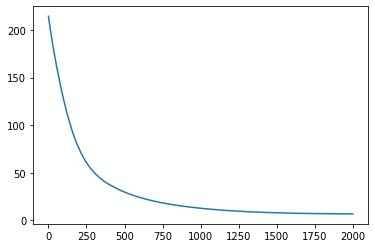

In [6]:
# Visualize the overall loss
plt.plot(losses)

In [7]:
# Found standard deviations (ground truth is 10 and 1):
std_1 = torch.exp(log_vars[0])**0.5
std_2 = torch.exp(log_vars[1])**0.5
print([std_1.item(), std_2.item()])

[8.153119087219238, 1.0081149339675903]
